In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../../source_code")

from loaders.output_loader import get_sorted_adj_mat_and_var_list
from loaders.import_gss import import_dataset
from loaders.clean_raw_data import clean_datasets

from generators.corr_make_network import calculate_correlation_matrix
from generators.graph_representation import create_graph_from_adj_mat

from analyzers.optimization_analyzer import multi_pass_optimize
from analyzers.optimization_analyzer import simulated_annealing
from analyzers.optimization_analyzer import hamiltonian_objective_function
from analyzers.optimization_analyzer import flip_step_function

from analyzers.frustration_analyzer import get_satisfaction_mats
from analyzers.frustration_analyzer import get_frust_percentage
from analyzers.frustration_analyzer import assign_nodes_search
from analyzers.frustration_analyzer import assign_nodes_random_walk

In [49]:
""" can generate the matrix from scratch or load it from a file """

from_scratch = True
start_year = 2012
interval = 4

if from_scratch:
    df, _ = import_dataset()
    cleaned_df = clean_datasets()
    years_of_interest = list(range(start_year, start_year + interval))
    corr_matrix = calculate_correlation_matrix(
        cleaned_df, 
        years_of_interest=years_of_interest,
        method="spearman", 
        partial=True, 
        edge_suppression="regularization",
        suppression_params={'regularization': 0.2})
    
    var_list = list(corr_matrix.columns)
    adj_mat = np.array(corr_matrix)
    
else:
    path = f"../../outputs/{start_year}-{start_year + interval}, R=0.2, Condition=None"
    adj_mat, var_list = get_sorted_adj_mat_and_var_list(path)

G = create_graph_from_adj_mat(adj_mat, variables_list=var_list)

Loading dataset from from cache...
Done! ✨
Loading dataset from from cache...
Done! ✨


In [50]:
n_vars = len(var_list)

In [51]:
""" find energy minima, and find how often each edge is frustrated """

initial_vectors = np.random.choice([-1, 0, 1], size=(1000, n_vars))
mp_minima, num_changed = multi_pass_optimize(initial_vectors, adj_mat, max_iterations=int(1e4))
satisfaction_mats = get_satisfaction_mats(adj_mat, mp_minima)
frust_percentage = get_frust_percentage(satisfaction_mats)

(array([272.,  44.,  48.,  32.,  64.,  38.,  94.,  90.,  50.,  60.,  18.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.    , 0.0493, 0.0986, 0.1479, 0.1972, 0.2465, 0.2958, 0.3451,
        0.3944, 0.4437, 0.493 , 0.5423, 0.5916, 0.6409, 0.6902, 0.7395,
        0.7888, 0.8381, 0.8874, 0.9367, 0.986 ]),
 <BarContainer object of 20 artists>)

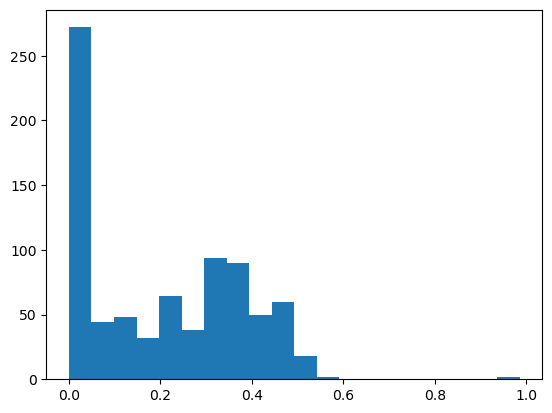

In [52]:
""" make a histogram of the frustrations """

plt.hist(frust_percentage[adj_mat != 0], bins=20)


In [53]:
""" Find energy minima using simulated annealing, and see how often each edge is frustrated """

initial_vectors = np.random.choice([-1, 0, 1], size=(1000, n_vars))
sa_minima, costs = simulated_annealing(initial_vectors, 100, 0.99, int(1e5), 
                              lambda vecs: hamiltonian_objective_function(vecs, adj_mat),
                              lambda vecs: flip_step_function(vecs, num_flips=1))


c:\Users\vicvi\BeliefNetworkEvo\CLEAN\notebooks\results\../../source_code\analyzers\optimization_analyzer.py:71: RuntimeWarning: overflow encountered in exp
  acceptance_prob_vector = np.where(new_cost_vector < old_cost_vector, 1, np.exp((old_cost_vector - new_cost_vector) / temperature))


In [54]:
""" calculate the frustration for the simulated annealing minima """

satisfaction_mats_sa = get_satisfaction_mats(adj_mat, sa_minima)
frust_percentage_sa = get_frust_percentage(satisfaction_mats_sa)

(array([300.,  58.,  54.,  26.,  60.,  86.,  58.,  40.,  58.,  52.,  16.,
          2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.    , 0.0471, 0.0942, 0.1413, 0.1884, 0.2355, 0.2826, 0.3297,
        0.3768, 0.4239, 0.471 , 0.5181, 0.5652, 0.6123, 0.6594, 0.7065,
        0.7536, 0.8007, 0.8478, 0.8949, 0.942 ]),
 <BarContainer object of 20 artists>)

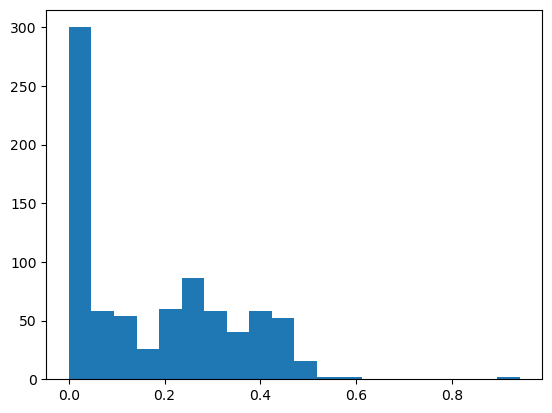

In [55]:
""" make a histogram of the frustrations """

plt.hist(frust_percentage_sa[adj_mat != 0], bins=20)

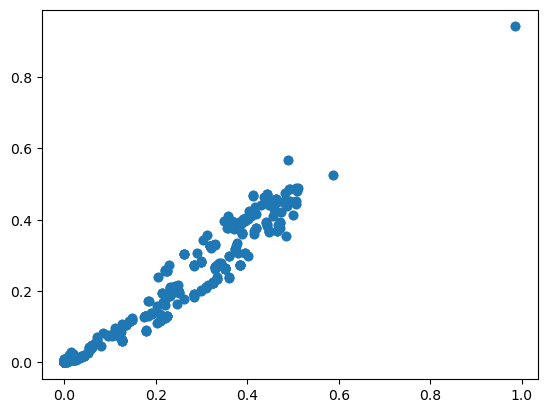

In [56]:
""" compare the minima with simulated annealing vs. multi-pass optimize """
plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_sa[adj_mat != 0])

In [57]:
""" print the most frustrated edges """
sorted_indices = np.unravel_index(np.argsort(frust_percentage, axis=None), frust_percentage.shape)

for i, j in zip(*sorted_indices):
    print(f"{var_list[i]} -> {var_list[j]}")

CAPPUN -> TEENSEX
CAPPUN -> COLMIL
CAPPUN -> LIBATH
CAPPUN -> CONBUS
CAPPUN -> SPKATH
CAPPUN -> POLABUSE
CAPPUN -> SUICIDE2
CAPPUN -> CONJUDGE
CAPPUN -> SPANKING
CAPPUN -> CONFINAN
CAPPUN -> ABRAPE
CAPPUN -> POLESCAP
CAPPUN -> CONCLERG
CAPPUN -> NATDRUGY
CAPPUN -> RACDIF4
CAPPUN -> CONPRESS
CAPPUN -> POLATTAK
CAPPUN -> COLMSLM
CAPPUN -> ABANY
CAPPUN -> LIBMSLM
CAPPUN -> POLHITOK
CAPPUN -> NATROAD
CAPPUN -> ABHLTH
CAPPUN -> OBEY
RELIG_Inter_nondenominational -> PRESLAST_NONCONFORM
CAPPUN -> NATRACEY
CAPPUN -> RACDIF3
CAPPUN -> HELPOTH
CAPPUN -> LIBCOM
CAPPUN -> AFFRMACT
CAPPUN -> CONLEGIS
CAPPUN -> SPKCOM
CAPPUN -> COLCOM
RELIG_Inter_nondenominational -> SPKMIL
RELIG_Inter_nondenominational -> FAIR
RELIG_Inter_nondenominational -> COLHOMO
RELIG_Inter_nondenominational -> PARTYID
RELIG_Inter_nondenominational -> SUICIDE1
RELIG_Inter_nondenominational -> CONARMY
RELIG_Inter_nondenominational -> NATSCI
RELIG_Inter_nondenominational -> ABPOOR
RELIG_Inter_nondenominational -> NATCITYY
RELIG_

In [58]:
""" print the most frustrated edges for simulated annealing """
sorted_indices_sa = np.unravel_index(np.argsort(frust_percentage_sa, axis=None), frust_percentage_sa.shape)

for i, j in zip(*sorted_indices_sa):
    print(f"{var_list[i]} -> {var_list[j]}")

CAPPUN -> TEENSEX
CAPPUN -> COLMIL
CAPPUN -> LIBATH
CAPPUN -> CONBUS
CAPPUN -> SPKATH
CAPPUN -> POLABUSE
CAPPUN -> SUICIDE2
CAPPUN -> CONJUDGE
CAPPUN -> SPANKING
CAPPUN -> CONFINAN
CAPPUN -> ABRAPE
CAPPUN -> POLESCAP
CAPPUN -> CONCLERG
CAPPUN -> NATDRUGY
CAPPUN -> RACDIF4
CAPPUN -> CONPRESS
CAPPUN -> POLATTAK
CAPPUN -> COLMSLM
CAPPUN -> ABANY
CAPPUN -> LIBMSLM
CAPPUN -> POLHITOK
CAPPUN -> NATROAD
CAPPUN -> ABHLTH
CAPPUN -> OBEY
RELIG_Inter_nondenominational -> PRESLAST_NONCONFORM
CAPPUN -> NATRACEY
CAPPUN -> RACDIF3
CAPPUN -> HELPOTH
CAPPUN -> LIBCOM
CAPPUN -> AFFRMACT
CAPPUN -> CONLEGIS
CAPPUN -> SPKCOM
CAPPUN -> COLCOM
RELIG_Inter_nondenominational -> SPKMIL
RELIG_Inter_nondenominational -> FAIR
RELIG_Inter_nondenominational -> COLHOMO
RELIG_Inter_nondenominational -> PARTYID
RELIG_Inter_nondenominational -> SUICIDE1
RELIG_Inter_nondenominational -> CONARMY
RELIG_Inter_nondenominational -> NATSCI
RELIG_Inter_nondenominational -> ABPOOR
RELIG_Inter_nondenominational -> NATCITYY
RELIG_

In [59]:
""" get a set of vector assignments by doing breadth first search on the graph"""

bfs_vectors = np.zeros((1000, 102))
for i in range(1000):
    assignments = assign_nodes_search(G, breadth_first=True)
    
    for j, node in enumerate(var_list):
        bfs_vectors[i, j] = assignments[node][0]  

IndexError: index 102 is out of bounds for axis 1 with size 102

(array([552.,  98.,  28.,   8.,  12.,   4.,   0.,   0.,   4.,   0.,   2.,
          0.,   0.,   0.,   2.,   4.,   2.,   4.,   4.,   2.]),
 array([0.     , 0.03315, 0.0663 , 0.09945, 0.1326 , 0.16575, 0.1989 ,
        0.23205, 0.2652 , 0.29835, 0.3315 , 0.36465, 0.3978 , 0.43095,
        0.4641 , 0.49725, 0.5304 , 0.56355, 0.5967 , 0.62985, 0.663  ]),
 <BarContainer object of 20 artists>)

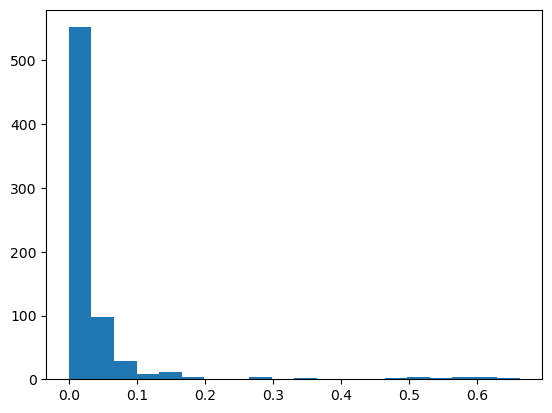

In [ ]:
""" make a histogram of the frustrations for breadth first search """

satisfaction_mats_bfs = get_satisfaction_mats(adj_mat, bfs_vectors)
frust_percentage_bfs = get_frust_percentage(satisfaction_mats_bfs)

plt.hist(frust_percentage_bfs[adj_mat != 0], bins=20)

In [ ]:
"""
make the networkx graph of the adjacency matrix, because thisis how I implemented the breadth first search
"""

'\nmake the networkx graph of the adjacency matrix, because thisis how I implemented the breadth first search\n'

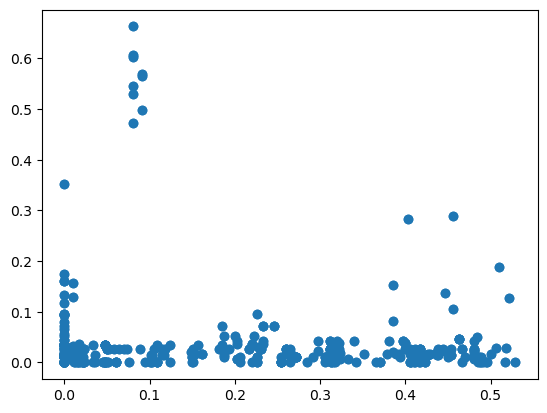

In [ ]:
""" see if bfs frustration is related to the one we get from the optimization functions """

plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_bfs[adj_mat != 0])

In [ ]:
""" get a set of vector assignments by doing a random walk on the graph"""

rw_vectors = np.zeros((1000, 102))
for i in range(100):
    assignments = assign_nodes_random_walk(G, weighted=True, iterations_per_node=100)
    
    for j, node in enumerate(var_list):
        rw_vectors[i, j] = assignments[node] 

(array([650.,   2.,  34.,  14.,   0.,   0.,  10.,   4.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   4.]),
 array([0.    , 0.0037, 0.0074, 0.0111, 0.0148, 0.0185, 0.0222, 0.0259,
        0.0296, 0.0333, 0.037 , 0.0407, 0.0444, 0.0481, 0.0518, 0.0555,
        0.0592, 0.0629, 0.0666, 0.0703, 0.074 ]),
 <BarContainer object of 20 artists>)

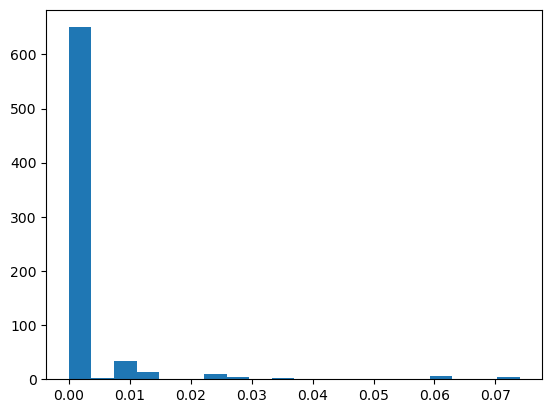

In [ ]:
""" make a histogram of the frustrations """

frust_mat_rw = get_satisfaction_mats(adj_mat, rw_vectors)
frust_percentage_rw = get_frust_percentage(frust_mat_rw)

plt.hist(frust_percentage_rw[adj_mat != 0], bins=20)

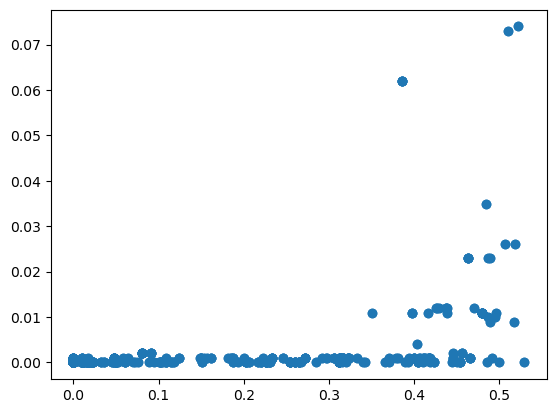

In [ ]:
""" are the random walk frustrations related to the optimization frustrations?
    yes, in some way, it seems that the ones with high frustration in the optimization have potential to be more frustrated 
    in the random walk, but they can also be unfrustrated.
"""
plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_rw[adj_mat != 0])

[np.float64(2.960124750720644e-05), np.float64(0.0031870513939476547), np.float64(0.005775797162370434), np.float64(0.009451642848396887), np.float64(0.0128977371070819), np.float64(0.016881155980749216), np.float64(0.02097195784147183), np.float64(0.026311076301743078), np.float64(0.03132957146925145), np.float64(0.038115949775579), np.float64(0.04476364827815446), np.float64(0.05638447828144186), np.float64(0.06783295244923604), np.float64(0.07855933541868916), np.float64(0.10049296755885467), np.float64(0.12411106460813966), np.float64(0.15294461759924508), np.float64(0.20042749303314455), np.float64(0.34673992487366445)]


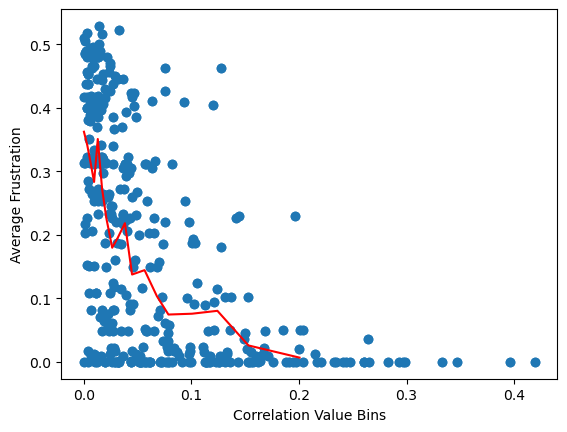

In [ ]:
""" plot frustration as it relates to the strength of the partial correlation """
plt.scatter(np.abs(adj_mat[adj_mat != 0]), frust_percentage[adj_mat != 0])

""" plot the average frustration for each window of correlation values """
# Calculate the absolute values of the non-zero correlations
abs_correlations = np.abs(adj_mat[adj_mat != 0])

# Sort the absolute correlations
sorted_correlations = np.sort(abs_correlations)

# Determine the bin edges such that each bin has 50 entries
bin_edges = [sorted_correlations[i] for i in range(0, len(sorted_correlations), 40)]
print(bin_edges)

bin_edges[-1] = sorted_correlations[-1] # Ensure the last edge includes the maximum value

# Calculate the average frustration for each bin
bin_means = []

for i in range(len(bin_edges) - 1):
    bin_mask = (abs_correlations >= bin_edges[i]) & (abs_correlations < bin_edges[i + 1])
    bin_means.append(frust_percentage[adj_mat != 0][bin_mask].mean())

# Plot the average frustration for each bin
plt.plot(bin_edges[:-1], bin_means, color="r")
plt.xlabel('Correlation Value Bins')
plt.ylabel('Average Frustration')
plt.show()

In [ ]:
""" TODO move this testing stuff to a proper file """
test_adj_mat = np.array([[1, 2, 3],
                         [4, 5, 6],
                         [7, 8, 9]])

test_vectors = np.array([[-1,  1, -1],
                         [ 1, -1,  1],
                         [-1, -1,  1],
                         [ 1, -1, -1],
                         [-1, -1, -1]])

expected_quad_form = np.array([[[1, -2, 3],[-4, 5, -6],[7, -8, 9]],
                               [[1, -2, 3],[-4, 5, -6],[7, -8, 9]],
                               [[1,  2, -3],[4, 5, -6],[-7, -8, 9]],
                               [[1, -2, -3],[-4, 5, 6],[-7, 8, 9]],
                               [[1, 2, 3],[4, 5, 6], [7, 8, 9]]])

np.testing.assert_array_equal(expected_quad_form, get_frust_mat(test_adj_mat, test_vectors))